In [ ]:
!git clone https://github.com/d-uni/LPPL_model.git
%cd LPPL_model

In [ ]:
from model_lppls import ModelLPPLS
from rolling_calibrator import RollingLPPLCalibrator
from distribution_calibrators import (
    DistributionLPPLCalibrator_for_different_Windows,
    DistributionLPPLCalibrator_for_different_Dates,
)
from visualization import plot_lppls_results, plot_tc_distribution,plot_combined_tc_distributions

# Test model_lppls.py

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download("000001.SS", start="2007-01-01", end="2008-01-01")
price_series = data["Close"].dropna()

t1 = "2007-03-12"
t2 = "2007-10-10"
fit_window = price_series[t1:t2]


dates = pd.to_datetime(fit_window.index)
t = (dates - dates[0]).days / 365.25  # time in years since start
p = fit_window.values  # price values

initial_guess = [t[-1] + 0.08, 0.5, 9.0]

model = ModelLPPLS(t, p)
model.set_calibration_date(t2)

model.fit(initial_guess)
model.summary()

[*********************100%***********************]  1 of 1 completed


,calibration_date,tc,A,B,C1,C2,m,omega,kappa,sign
0,2007-10-10,0.61756,9.220975,-1.289943,-0.015782,0.027368,0.308668,13.0,1.289943,1


# Test rolling_calibrator.py

In [ ]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2020-01-01", "2025-10-29"
data_rolling_calibrator  = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_rolling_calibrator
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()



rolling_calibrator = RollingLPPLCalibrator(t_series, p_series)
rolling_calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)

# ------ Acceptance thresholds
rolling_calibrator.set_acceptance_thresholds(
    r2_min=0.95, rmse_max=0.04, kappa_min=0.05, tc_horizon_years=0.5
)

result_rolling_calibrator = rolling_calibrator.run(
    start_roll = 1.0,       # start of rolling period (years)
    end_roll = 4.0,         # end of rolling period (years)
    window_years = 1.0,     # window size
    step_years = 4 / 365.25 # step = 2 days
)

In [ ]:
result_rolling_calibrator.head()

,window_start,window_end,window_size,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,0.229979,1.229979,1.0,1.609081,8.473728,-0.392700,0.031156,0.008641,0.900000,10.761981,0.955097,0.023548,0.392700,1
1,0.240931,1.240931,1.0,1.678745,8.497749,-0.390976,0.014015,0.025291,0.900000,11.779332,0.955373,0.023112,0.390976,1
2,0.251882,1.251882,1.0,1.263980,8.319483,-0.338484,-0.041497,0.010979,0.900000,8.052974,0.963321,0.019927,0.338484,1
3,0.273785,1.273785,1.0,1.563922,8.433021,-0.358677,0.021824,-0.013189,0.900000,11.624131,0.962764,0.019829,0.358677,1
4,0.284736,1.284736,1.0,1.722421,8.499939,-0.373940,0.002450,0.022289,0.892768,12.999996,0.965764,0.018995,0.373940,1


# Test distribution_calibrators.py

In [ ]:
target_date_ = pd.Timestamp("2010-01-01")

SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2011-01-01"
data_tc_distribution_over_window = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_window
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

calibrator = DistributionLPPLCalibrator_for_different_Windows(t_series, p_series)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)

# --- Acceptance thresholds ---
calibrator.set_acceptance_thresholds(
    r2_min=0.9,
    rmse_max=0.06,
    kappa_min=0.05,
    tc_horizon_years=0.5
)

target_date = (target_date_ - data.index[0]).days / 365.25 #!!!!!!! <- <- <- <- <- <- CONSIDER TARGET DAY

result_tc_distribution_over_window = calibrator.tc_distribution_over_window(
    target_date=target_date,
    min_window_years=1/12,  # 1 month
    max_window_years=1.0,   # 1 year
    step_window_years=1/365.25, # increment by 1 day
    acceptance_thresholds=True # IF you put False -> you don't take into account the thresholds, presented earlier
)

In [ ]:
result_tc_distribution_over_window.head()

,window_years,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,0.693874,4.422385,7.222396,-0.386712,-0.024356,0.010049,0.900000,9.193598,0.931127,0.021413,0.386712,1
1,0.702088,4.301180,7.169306,-0.373429,-0.016190,0.025422,0.899994,6.948565,0.929965,0.022217,0.373429,1
2,0.704825,4.301180,7.169306,-0.373429,-0.016190,0.025422,0.899994,6.948565,0.929965,0.022217,0.373429,1
3,0.707563,4.301180,7.169306,-0.373429,-0.016190,0.025422,0.899994,6.948565,0.929965,0.022217,0.373429,1
4,0.721253,4.264835,7.170400,-0.384324,-0.019895,0.024653,0.831907,6.000148,0.933984,0.022224,0.384324,1


In [ ]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2011-01-01"
data_tc_distribution_over_dates = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_dates
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

# --- Initialize calibrator ---
calibrator = DistributionLPPLCalibrator_for_different_Dates(t_series, p_series)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
calibrator.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

# --- Parameters ---
target_date = (target_date_ - data.index[0]).days / 365.25
window_years = 1.0                 # fixed calibration window
distribution_window_years = 1/12    # look 6 months before target date
step_years = 1 / 365.25            # 5 days between calibrations

# --- Run distribution over calibration dates ---
result_tc_distribution_over_dates = calibrator.tc_distribution_over_dates(
    target_date=target_date,
    window_years=window_years,
    distribution_window_years=distribution_window_years,
    step_years=step_years,
    acceptance_thresholds=True
)

In [ ]:
result_tc_distribution_over_dates.head()

,calibration_date,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,3.930356,3.928818,7.032827,-0.397201,0.091216,-0.075049,0.899999,12.096744,0.904176,0.036374,0.397201,1
1,3.933094,3.962349,7.046763,-0.396922,0.109775,-0.012740,0.900000,11.802792,0.901475,0.037020,0.396922,1
2,3.935832,3.994441,7.060970,-0.400738,0.102379,0.024334,0.900000,12.439329,0.903708,0.036747,0.400738,1
3,3.938569,3.966512,7.048812,-0.398927,0.107952,-0.010710,0.900000,11.950389,0.904006,0.036828,0.398927,1
4,3.941307,3.961055,7.046500,-0.399459,0.106552,-0.020829,0.900000,11.975183,0.904136,0.036861,0.399459,1


# Test visualization.py

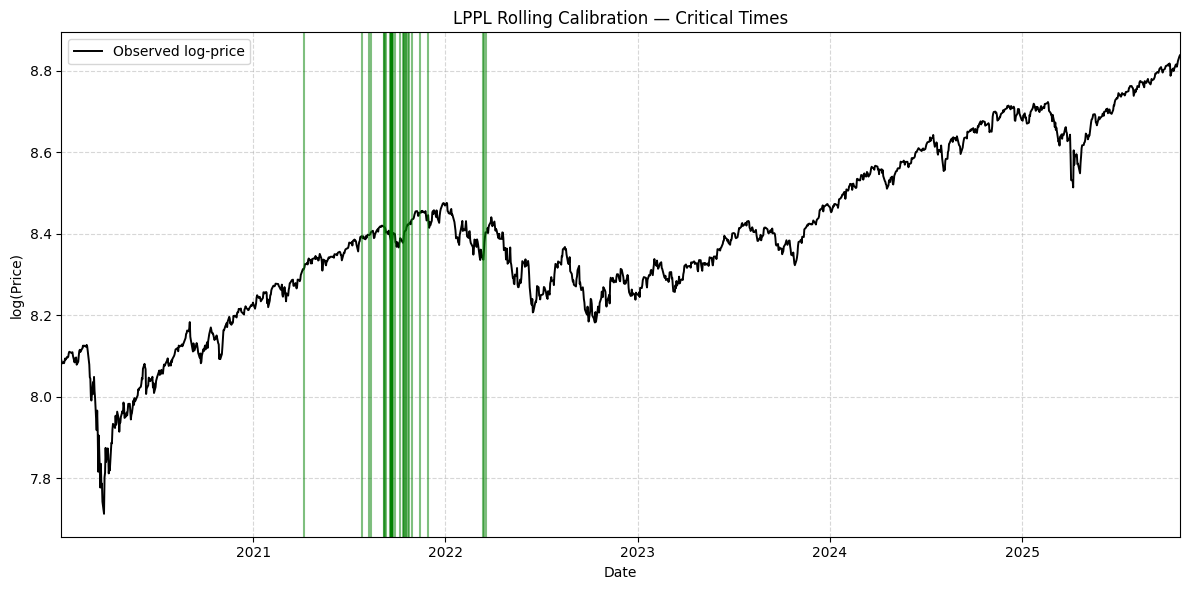

In [ ]:
plot_lppls_results(data_rolling_calibrator, result_rolling_calibrator)

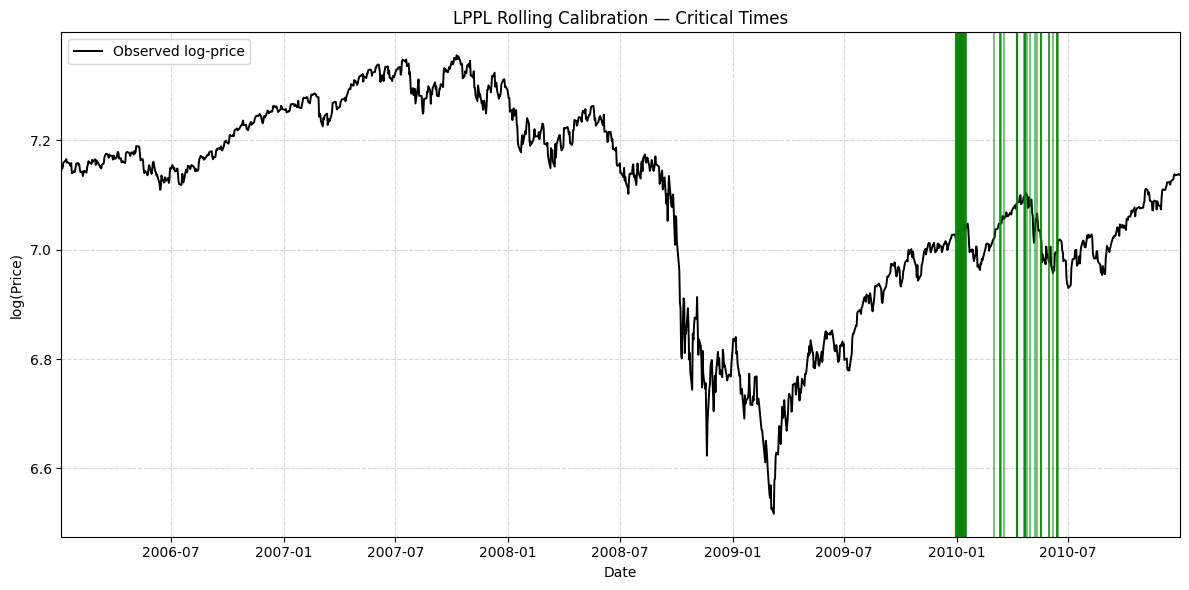

In [ ]:
plot_lppls_results(data_tc_distribution_over_window, result_tc_distribution_over_window)

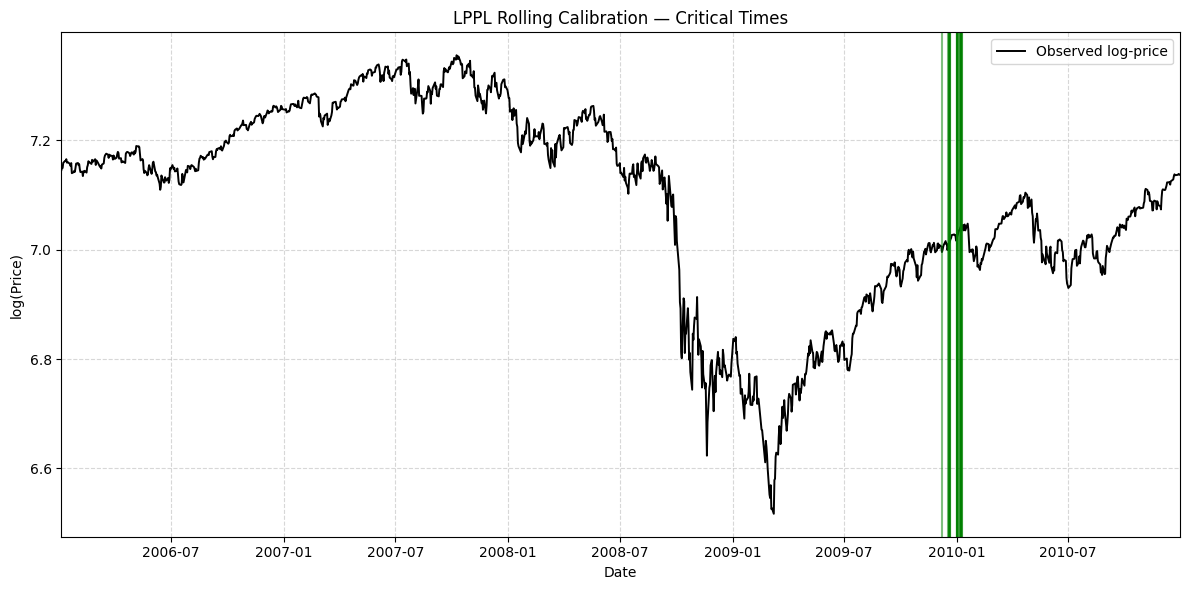

In [ ]:
plot_lppls_results(data_tc_distribution_over_dates, result_tc_distribution_over_dates)

In [ ]:
tc_predicted_from_start_dates = result_tc_distribution_over_dates["tc"]-(target_date_ - data_tc_distribution_over_dates.index[0]).days / 365.25

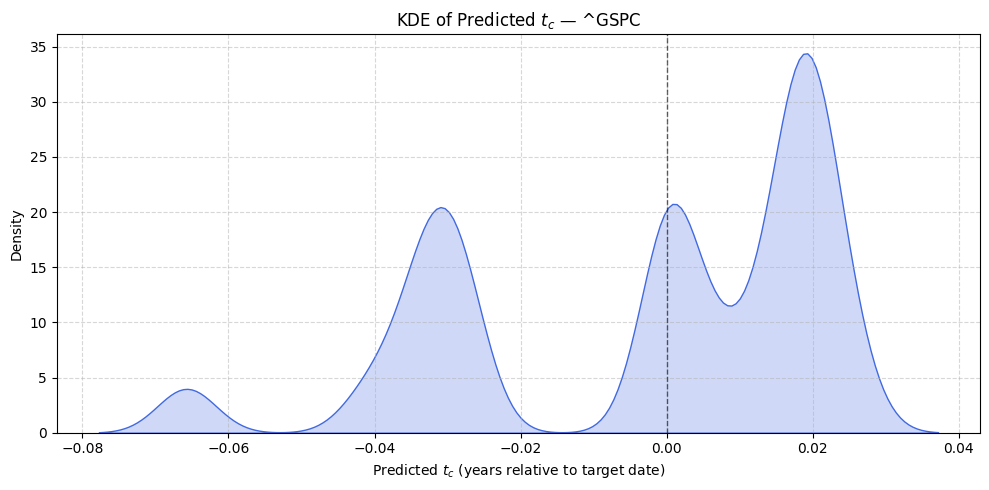

In [ ]:
plot_tc_distribution(tc_predicted_from_start_dates, symbol=SYMBOL)

In [ ]:
tc_predicted_from_start_window = result_tc_distribution_over_window["tc"]-(target_date_ - data_tc_distribution_over_window.index[0]).days / 365.25

In [ ]:
result_tc_distribution_over_window["tc"]

0     4.422385
1     4.301180
2     4.301180
3     4.301180
4     4.264835
        ...   
56    3.995646
57    4.036008
58    4.014397
59    4.015301
60    4.015301
Name: tc, Length: 61, dtype: float64

In [ ]:
data_tc_distribution_over_window.index[0]

Timestamp('2006-01-03 00:00:00')

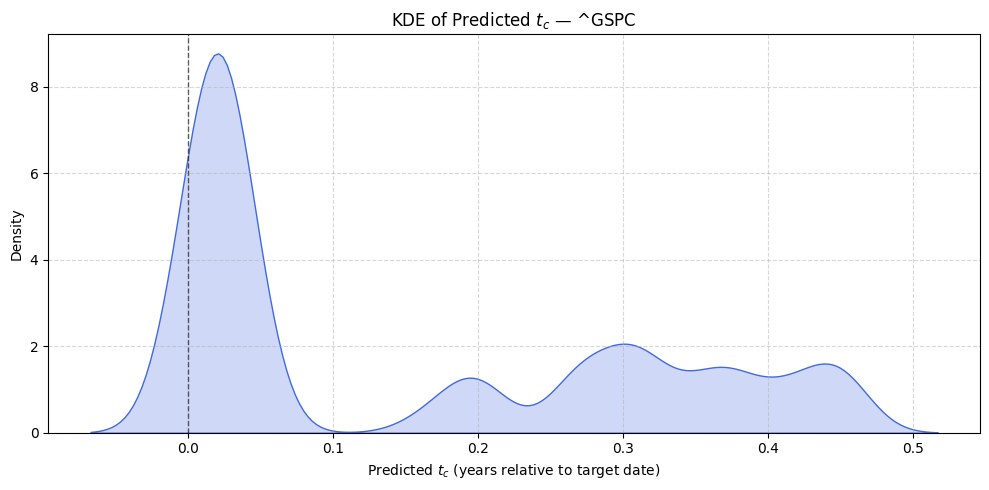

In [ ]:
plot_tc_distribution(tc_predicted_from_start_window, symbol=SYMBOL)

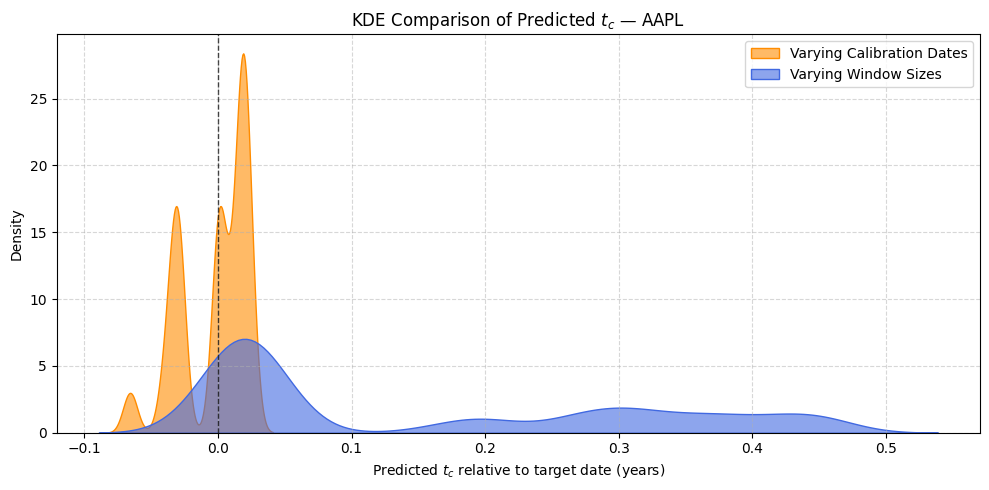

In [ ]:
plot_combined_tc_distributions(tc_predicted_from_start_dates, tc_predicted_from_start_window, symbol=SYMBOL)